# EcoFOCIpy SBE16 QC example (seperated)

see [EcoFOCIpy_19bs8a_sbe16_4139.ipynb](EcoFOCIpy_19bs8a_sbe16_4139.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

import ecofocipy.metaconfig.load_config as load_config

In [2]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2019/Moorings/19bs8a/'

In [3]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'rawconverted/sbe16/19bs8a_sbe16_4139_20m_rerun.cnv'
instrument = 'SBE-16 4139'
mooring_meta_file = user_data_dir+'logs/19BS-8A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe16_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's16'
###############################################################


NameError: name 'mooring_config' is not defined

In [4]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [5]:
depth = '0019'
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'

### QC Notes from plots

- **no pressure var - so assume pressure correction from other depths**
- Salinity Spikes mid campaign and near the end should be removed
- rough field check points look good


### Post Manual QC load data and rebuild nc file

- using excel for a few points or a dynamic web map for multiple (a tool on ecofoci-field.pmel.noaa.gov) or any other method to identify spikes
**NOTE** if you use excel, be cautious about how your time is formatted (its important) - use custom formatting and make it of the form `yyyy-mm-ddTHH:MM:SSZ` to assure proper read in to xarray

*TODO:* use erddap hosted data 

In [6]:
# this reads the previous csv and assumes you've made modifications to the content but not the structure (record length or variable names)
try:
    sbe16_df_qc = pd.read_csv(user_data_dir+'working/'+filename.replace('nc','csv'), index_col=['time','depth','latitude','longitude']) #order is important
except:
    sbe16_df_qc = pd.read_csv(user_data_dir+'working/'+filename.replace('nc','csv'), index_col=['time (UTC)','depth (m)','latitude (degrees_north)','longitude (degrees_east)']) #order is important


In [7]:
# this loads the initial working netcdf file
sbe16_wop_nc_qc = xr.load_dataset(user_data_dir+'working/'+filename)

In [8]:
sbe16_wop_nc_qc

<xarray.Dataset>
Dimensions:      (time: 18778, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-23T23:00:00 ... 2021-11-14T08:...
  * latitude     (latitude) float64 62.2
  * longitude    (longitude) float64 -174.7
  * depth        (depth) float64 19.0
Data variables:
    salinity     (time, depth, latitude, longitude) float64 32.06 ... 32.42
    temperature  (time, depth, latitude, longitude) float64 8.892 ... 1.451
Attributes: (12/33)
    Latitude_DegMMddW:                      62 12.00 N
    Longitude_DegMMddN:                     174 40.770 W
    MooringID:                              19BS-8A
    platform_deployment_date:               2019-09-23T22:49:00Z
    platform_deployment_cruise_name:        DY1908
    platform_recovery_date:                 2021-11-14T08:11:00Z
    ...                                     ...
    InstrumentSerialNumber:                 4139
    InstrumentType:                         SBE-16
    date_created:                           2022-12-16T06:22:54Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

In [9]:
#replace original data with editied data
sbe16_wop_nc_qc['temperature'].values=xr.Dataset.from_dataframe(sbe16_df_qc)['temperature']
sbe16_wop_nc_qc['salinity'].values=xr.Dataset.from_dataframe(sbe16_df_qc)['salinity']

In [10]:
import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

url = "http://akutan.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [11]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy1908',qclevel='final',concastno='009')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='024')

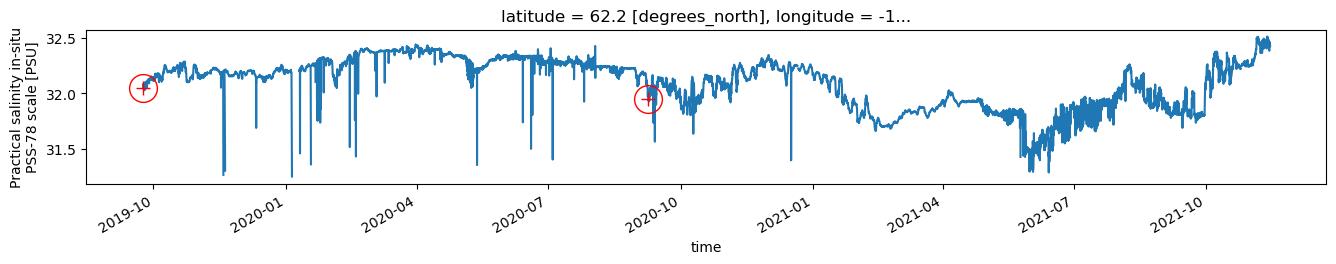

In [12]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe16_wop_nc_qc.salinity.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

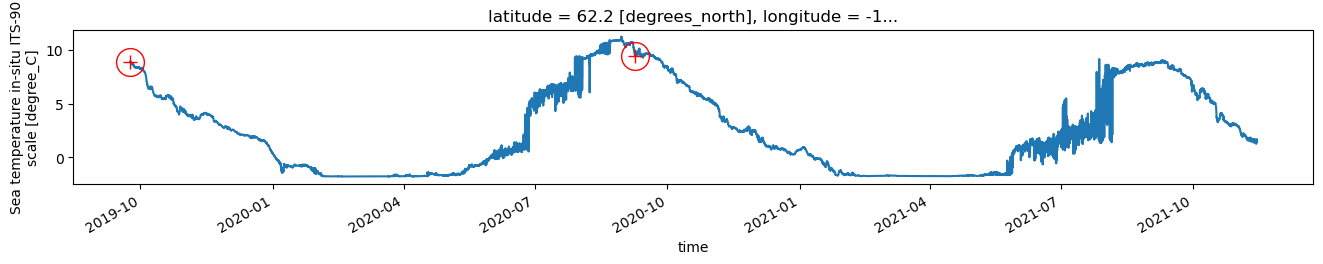

In [13]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])

fig, ax = plt.subplots(1,figsize=(16, 2))
sbe16_wop_nc_qc.temperature.plot(x="time",hue="depth",ax=ax, add_legend=False);
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['T_28 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(depcast[depcast['pressure (dbar)'] == depth]['time (UTC)']),
        depcast[depcast['pressure (dbar)'] == depth]['T_28 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['T_28 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax.plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time (UTC)']),
        reccast[reccast['pressure'] == depth]['T_28 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### Update global attributes

In [14]:
sbe16_wop_nc_qc.attrs.update({'QC_indicator': 'ProbablyGood'})
sbe16_wop_nc_qc.attrs.update({'history':(sbe16_wop_nc_qc.history + "\nQCd: "+ str(datetime.datetime.today()))})

In [15]:
sbe16_wop_nc_qc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [16]:
sbe16_wop_nc_qc.to_netcdf(user_data_dir+'working/'+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})